# Predict Home Value of Zillow Listings

**Alec Hartman**

**April 13, 2020**

## Goals
1. Develop a model to predict home values using square feet, bedrooms, and bathrooms. Do this for each feature individually and then create a model using all features in concert.
2. Plot distributions of tax rates for each county, and provide key measures of central tendency and measures of spread.
3. Create a summary presentation about the drivers of single unit property values

---
### 1. Acquire + Preparation aka Wrangling

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math
import sklearn
import sklearn.linear_model

import wrangle as wr
import split_scale as ss
import explore as ex
import evaluate as ev

In [2]:
df = wr.wrangle_zillow()
df

,bathrooms,bedrooms,square_feet,fips_code,property_description,home_value,tax_amount,tax_rate,transaction_date,county
0,2.5,3.0,1653.0,6059,Single Family Residential,605000.0,6185.28,0.010224,2017-05-01,Orange County
1,3.0,3.0,1572.0,6037,Single Family Residential,404060.0,4934.43,0.012212,2017-05-01,Los Angeles County
2,3.0,4.0,3041.0,6037,Single Family Residential,245311.0,2963.65,0.012081,2017-05-01,Los Angeles County
3,2.0,3.0,1692.0,6037,Single Family Residential,649169.0,8063.11,0.012421,2017-05-01,Los Angeles County
4,2.0,4.0,1611.0,6037,Single Family Residential,89640.0,1144.73,0.012770,2017-05-01,Los Angeles County
...,...,...,...,...,...,...,...,...,...,...
14984,3.0,5.0,2526.0,6059,Single Family Residential,458903.0,5718.72,0.012462,2017-06-30,Orange County
14985,3.0,5.0,2735.0,6059,Single Family Residential,115387.0,1465.88,0.012704,2017-06-30,Orange County
14986,2.0,3.0,1536.0,6037,Single Family Residential,297097.0,3519.78,0.011847,2017-06-30,Los Angeles County
14987,3.0,5.0,2655.0,6059,Single Family Residential,746963.0,8065.50,0.010798,2017-06-30,Orange County


#### In which state and counties are these listing located?

In [3]:
df.county.unique()

array(['Orange County', 'Los Angeles County', 'Ventura County'],
      dtype=object)

> The county feature was aquired by researching FIPS codes. The Federal Communications Commission (FCC) has provided a key for all FIPS codes in the United States. All properties contained in the DataFrame above are in the California counties of Los Angeles, Orange, and Ventura. You can reference the website where this information was found by following this [link](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt).

#### Let's ensure our data is truly ready to analyze.

In [4]:
assert (df.bathrooms == 0).sum() == 0, "If you see an Assert Error, there are zero values in the bathrooms feature."
assert (df.bedrooms == 0).sum() == 0, "If you see an Assert Error, there are zero values in the bedrooms feature."
assert (df.square_feet == 0).sum() == 0, "If you see an Assert Error, there are zero values in the square_feet feature."
assert (df.fips_code == 0).sum() == 0, "If you see an Assert Error, there are zero values in the fips_code feature."
assert (df.home_value == 0).sum() == 0, "If you see an Assert Error, there are zero values in the tax_value feature."
assert (df.tax_amount == 0).sum() == 0, "If you see an Assert Error, there are zero values in the tax_amount feature."
assert (df.tax_rate == 0).sum() == 0, "If you see an Assert Error, there are zero values in the tax_rate feature."

In [5]:
df.isnull().sum()

bathrooms               0
bedrooms                0
square_feet             0
fips_code               0
property_description    0
home_value              0
tax_amount              0
tax_rate                0
transaction_date        0
county                  0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14989 entries, 0 to 14988
Data columns (total 10 columns):
bathrooms               14989 non-null float64
bedrooms                14989 non-null float64
square_feet             14989 non-null float64
fips_code               14989 non-null int64
property_description    14989 non-null object
home_value              14989 non-null float64
tax_amount              14989 non-null float64
tax_rate                14989 non-null float64
transaction_date        14989 non-null object
county                  14989 non-null object
dtypes: float64(6), int64(1), object(3)
memory usage: 1.1+ MB


In [7]:
df.describe()

,bathrooms,bedrooms,square_feet,fips_code,home_value,tax_amount,tax_rate
count,14989.000000,14989.000000,14989.000000,14989.000000,1.498900e+04,14989.000000,14989.000000
mean,2.329175,3.316899,1943.199013,6049.382547,5.417072e+05,6597.894501,0.013430
std,1.019406,0.936278,1001.275534,21.226074,7.309616e+05,8453.776520,0.006885
min,1.000000,1.000000,300.000000,6037.000000,1.050400e+04,51.260000,0.000787
25%,2.000000,3.000000,1276.000000,6037.000000,1.990000e+05,2710.810000,0.011602
50%,2.000000,3.000000,1680.000000,6037.000000,3.852590e+05,4776.080000,0.012305
75%,3.000000,4.000000,2346.000000,6059.000000,6.449720e+05,7678.440000,0.013693
max,11.000000,12.000000,15450.000000,6111.000000,2.385837e+07,276797.830000,0.452884


In [8]:
train, test = ss.split_my_data(df)

In [9]:
train

,bathrooms,bedrooms,square_feet,fips_code,property_description,home_value,tax_amount,tax_rate,transaction_date,county
14440,2.0,3.0,1410.0,6037,Single Family Residential,100794.0,2269.73,0.022519,2017-06-30,Los Angeles County
6848,1.0,2.0,806.0,6037,Single Family Residential,270789.0,3686.09,0.013612,2017-05-31,Los Angeles County
14624,2.0,3.0,1821.0,6037,Single Family Residential,238358.0,3132.04,0.013140,2017-06-30,Los Angeles County
10263,2.0,4.0,1697.0,6111,Single Family Residential,365558.0,4139.56,0.011324,2017-06-15,Ventura County
4870,2.0,3.0,1618.0,6059,Single Family Residential,70667.0,1038.24,0.014692,2017-05-23,Orange County
...,...,...,...,...,...,...,...,...,...,...
9451,2.0,3.0,1203.0,6059,Single Family Residential,248385.0,3036.98,0.012227,2017-06-12,Orange County
13730,5.0,4.0,4691.0,6037,Single Family Residential,3907446.0,46132.50,0.011806,2017-06-28,Los Angeles County
3264,1.5,4.0,1032.0,6059,Single Family Residential,495000.0,5783.48,0.011684,2017-05-15,Orange County
399,1.0,2.0,890.0,6037,Single Family Residential,453000.0,5320.31,0.011745,2017-05-02,Los Angeles County


In [10]:
test

,bathrooms,bedrooms,square_feet,fips_code,property_description,home_value,tax_amount,tax_rate,transaction_date,county
7790,2.5,3.0,2210.0,6059,Single Family Residential,949258.0,9624.54,0.010139,2017-06-02,Orange County
406,2.5,4.0,2373.0,6059,Single Family Residential,674071.0,7572.44,0.011234,2017-05-02,Orange County
5985,2.0,4.0,1919.0,6037,Single Family Residential,286663.0,5219.87,0.018209,2017-05-26,Los Angeles County
5554,2.0,4.0,1600.0,6059,Single Family Residential,400489.0,4608.84,0.011508,2017-05-25,Orange County
14479,3.0,3.0,1824.0,6037,Single Family Residential,495000.0,6126.89,0.012378,2017-06-30,Los Angeles County
...,...,...,...,...,...,...,...,...,...,...
14044,1.0,3.0,936.0,6037,Single Family Residential,68503.0,876.71,0.012798,2017-06-29,Los Angeles County
11630,1.0,2.0,760.0,6037,Single Family Residential,187239.0,2615.27,0.013968,2017-06-20,Los Angeles County
14797,2.0,3.0,1346.0,6037,Single Family Residential,94310.0,1482.41,0.015718,2017-06-30,Los Angeles County
9853,3.0,4.0,1980.0,6037,Single Family Residential,220378.0,2863.89,0.012995,2017-06-13,Los Angeles County


In [11]:
train.shape[0] / df.shape[0]

0.7999866568817132

In [12]:
test.shape[0] / df.shape[0]

0.20001334311828675

In [13]:
train = train[["square_feet", "bedrooms", "bathrooms", "home_value"]]
test = test[["square_feet", "bedrooms", "bathrooms", "home_value"]]

In [14]:
train

,square_feet,bedrooms,bathrooms,home_value
14440,1410.0,3.0,2.0,100794.0
6848,806.0,2.0,1.0,270789.0
14624,1821.0,3.0,2.0,238358.0
10263,1697.0,4.0,2.0,365558.0
4870,1618.0,3.0,2.0,70667.0
...,...,...,...,...
9451,1203.0,3.0,2.0,248385.0
13730,4691.0,4.0,5.0,3907446.0
3264,1032.0,4.0,1.5,495000.0
399,890.0,2.0,1.0,453000.0


In [15]:
test

,square_feet,bedrooms,bathrooms,home_value
7790,2210.0,3.0,2.5,949258.0
406,2373.0,4.0,2.5,674071.0
5985,1919.0,4.0,2.0,286663.0
5554,1600.0,4.0,2.0,400489.0
14479,1824.0,3.0,3.0,495000.0
...,...,...,...,...
14044,936.0,3.0,1.0,68503.0
11630,760.0,2.0,1.0,187239.0
14797,1346.0,3.0,2.0,94310.0
9853,1980.0,4.0,3.0,220378.0


---
### 2. Explore

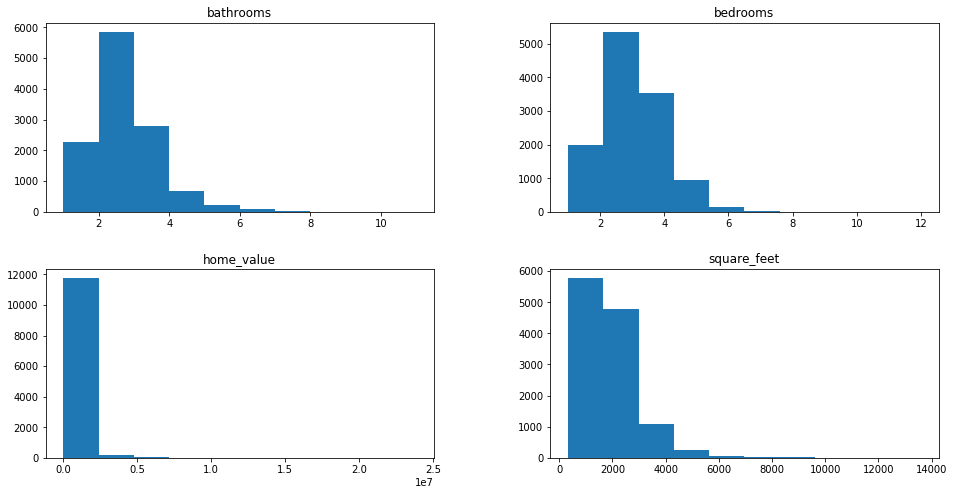

In [16]:
train.hist(grid=False, figsize=(16, 8))
plt.show()

---
#### Distribution of Tax Rates by County

> Note: Calculate mean, median, and standard deviation for each county's tax_rate distribution.

In [17]:
# def plot_tax_distribution(ax, tax_rate, county, data):
#     for c in county.unique():
#         plt.figure(figsize=(16, 4))
#         plt.title(f"Distribution of Tax Rates in {c}")
#         sns.distplot(data[data.c == c].tax_rate)
#         plt.xlabel("Tax Rate")
#         plt.show()

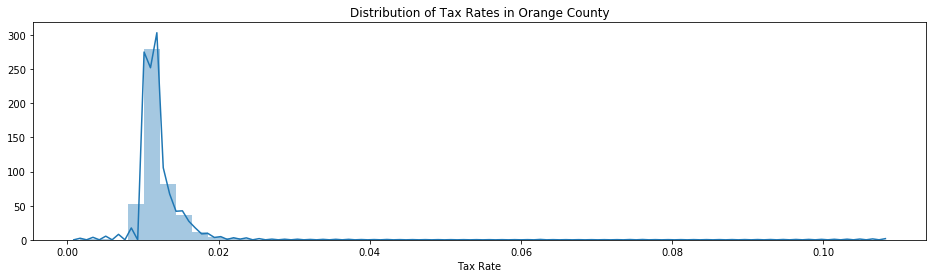

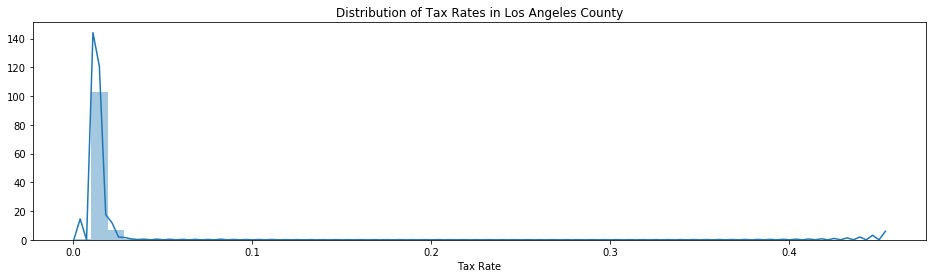

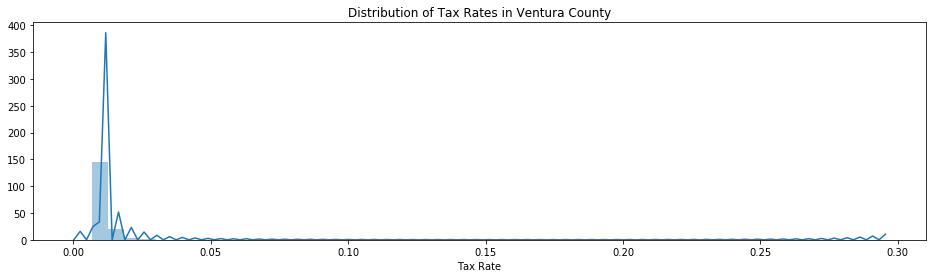

In [18]:
for county in df.county.unique():
    plt.figure(figsize=(16, 4))
    plt.title(f"Distribution of Tax Rates in {county}")
    sns.distplot(df[df.county == county].tax_rate)
    plt.xlabel("Tax Rate")
    plt.show()

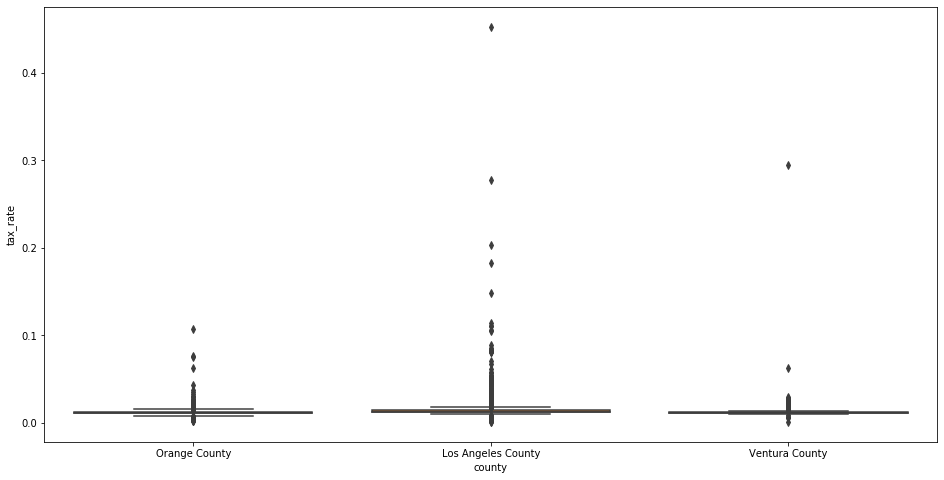

In [19]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.county, y=df.tax_rate)
plt.show()

---
### 3. Model

In [20]:
pd.options.display.float_format = '{:.3f}'.format

### Hypotheses

$H_0$: Single unit property value is independent of square footage, number of bedrooms, and number of bathrooms

$H_a$: Single unit property value is dependent on square footage, number of bedrooms, and number of bathrooms

In [21]:
train.home_value.mean(), train.home_value.median()

(539045.853056459, 387093.0)

> I chose the median home_value of the train dataset to be my baseline because the mean seems to be heavily influenced by the outliers.

In [22]:
predictions = pd.DataFrame({
    "actual_home_value": train.home_value,
    "baseline_home_value": train.home_value.median()
})
predictions

,actual_home_value,baseline_home_value
14440,100794.000,387093.000
6848,270789.000,387093.000
14624,238358.000,387093.000
10263,365558.000,387093.000
4870,70667.000,387093.000
...,...,...
9451,248385.000,387093.000
13730,3907446.000,387093.000
3264,495000.000,387093.000
399,453000.000,387093.000


In [23]:
# feature
X = train[["square_feet"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ square_feet"] = lm.predict(X)
predictions

,actual_home_value,baseline_home_value,home_value ~ square_feet
14440,100794.000,387093.000,307607.662
6848,270789.000,387093.000,47210.750
14624,238358.000,387093.000,484798.276
10263,365558.000,387093.000,431339.307
4870,70667.000,387093.000,397280.771
...,...,...,...
9451,248385.000,387093.000,218365.674
13730,3907446.000,387093.000,1722114.730
3264,495000.000,387093.000,144644.031
399,453000.000,387093.000,83424.890


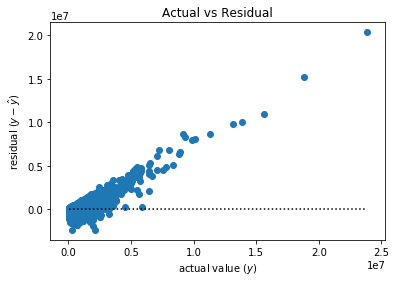

In [24]:
ev.plot_residuals(predictions.actual_home_value, predictions["home_value ~ square_feet"])
plt.show()

In [25]:
ev.regression_errors(predictions.actual_home_value, predictions["home_value ~ square_feet"], predictions)

SSE    3973079860291705.000
ESS    2165782278696725.000
TSS    6138862138988430.000
MSE        331338492226.812
RMSE             575620.094
dtype: float64

In [26]:
ev.baseline_errors(predictions.actual_home_value, predictions.baseline_home_value, predictions)

SSE_baseline    6415730366586437.000
MSE_baseline        535045481326.531
RMSE_baseline             731468.032
dtype: float64

In [27]:
ev.better_than_baseline(predictions.actual_home_value, predictions["home_value ~ square_feet"], predictions.baseline_home_value, predictions)

Model performs better than baseline


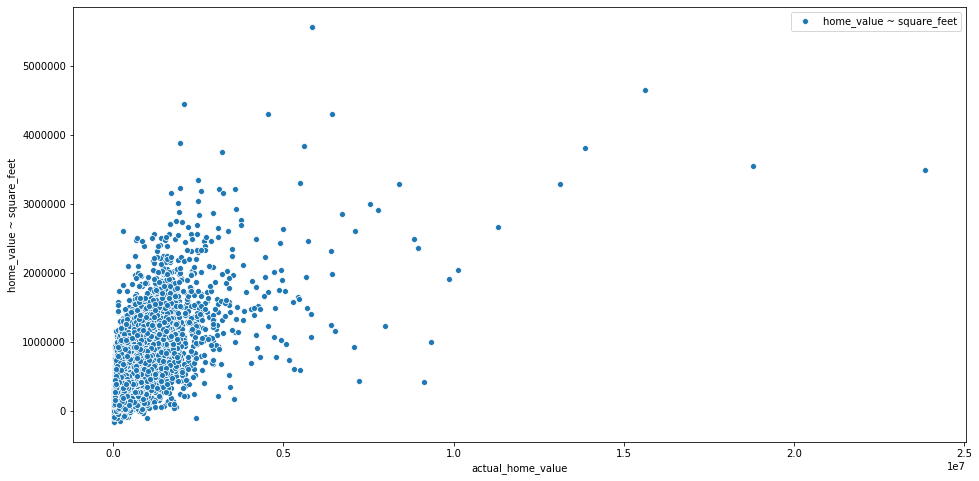

In [28]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x=predictions.actual_home_value, y=predictions["home_value ~ square_feet"], label="home_value ~ square_feet")

plt.show()

In [29]:
# feature
X = train[["bedrooms"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ bedrooms"] = lm.predict(X)
predictions

,actual_home_value,baseline_home_value,home_value ~ square_feet,home_value ~ bedrooms
14440,100794.000,387093.000,307607.662,471002.986
6848,270789.000,387093.000,47210.750,258084.923
14624,238358.000,387093.000,484798.276,471002.986
10263,365558.000,387093.000,431339.307,683921.049
4870,70667.000,387093.000,397280.771,471002.986
...,...,...,...,...
9451,248385.000,387093.000,218365.674,471002.986
13730,3907446.000,387093.000,1722114.730,683921.049
3264,495000.000,387093.000,144644.031,683921.049
399,453000.000,387093.000,83424.890,258084.923


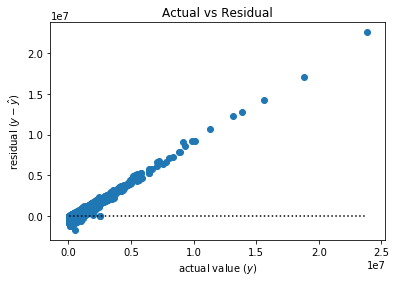

In [30]:
ev.plot_residuals(predictions.actual_home_value, predictions["home_value ~ bedrooms"])
plt.show()

In [31]:
# feature
X = train[["bathrooms"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ bathrooms"] = lm.predict(X)
predictions

,actual_home_value,baseline_home_value,home_value ~ square_feet,home_value ~ bedrooms,home_value ~ bathrooms
14440,100794.000,387093.000,307607.662,471002.986,418649.129
6848,270789.000,387093.000,47210.750,258084.923,54910.879
14624,238358.000,387093.000,484798.276,471002.986,418649.129
10263,365558.000,387093.000,431339.307,683921.049,418649.129
4870,70667.000,387093.000,397280.771,471002.986,418649.129
...,...,...,...,...,...
9451,248385.000,387093.000,218365.674,471002.986,418649.129
13730,3907446.000,387093.000,1722114.730,683921.049,1509863.880
3264,495000.000,387093.000,144644.031,683921.049,236780.004
399,453000.000,387093.000,83424.890,258084.923,54910.879


In [32]:
# feature
X = train[["square_feet", "bedrooms", "bathrooms"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ square_feet + bedrooms + bedrooms"] = lm.predict(X)
predictions

,actual_home_value,baseline_home_value,home_value ~ square_feet,home_value ~ bedrooms,home_value ~ bathrooms,home_value ~ square_feet + bedrooms + bedrooms
14440,100794.000,387093.000,307607.662,471002.986,418649.129,316618.996
6848,270789.000,387093.000,47210.750,258084.923,54910.879,113190.188
14624,238358.000,387093.000,484798.276,471002.986,418649.129,503913.254
10263,365558.000,387093.000,431339.307,683921.049,418649.129,310619.601
4870,70667.000,387093.000,397280.771,471002.986,418649.129,411405.384
...,...,...,...,...,...,...
9451,248385.000,387093.000,218365.674,471002.986,418649.129,222288.310
13730,3907446.000,387093.000,1722114.730,683921.049,1509863.880,1869907.056
3264,495000.000,387093.000,144644.031,683921.049,236780.004,-24908.471
399,453000.000,387093.000,83424.890,258084.923,54910.879,151469.307
